<a href="https://colab.research.google.com/github/thadd3us/ml_public/blob/main/CLIP_and_HuggingFace_CLIP_Preprocessing_Differences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I made this notebook to examine the differences between the HuggingFace implementation of CLIP and the version from OpenAI.

TL;DR: There are some small differences in the image processing.

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dkjhnsyj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-dkjhnsyj
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 293.1 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=e20b8c78ffb5452f532c23a4d9a679d3e2f7223bb6860443da80313540aa79a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-3vamajzj/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
# HuggingFace version comes with Colab.
from transformers import CLIPProcessor, CLIPModel

# CLIP version installed from GitHub.
import clip

import torch
import numpy as np
import PIL
import requests
import plotly.express as px
import plotly.graph_objects as go

In [3]:
hf_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
hf_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
clip_model, clip_preprocess = clip.load("ViT-L/14@336px")

100%|███████████████████████████████████████| 891M/891M [00:17<00:00, 54.4MiB/s]


In [5]:
clip_preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x7a6957fc20e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
hf_processor.image_processor

CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  },
  "use_square_size": false
}

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x467 at 0x7A690F502B60>


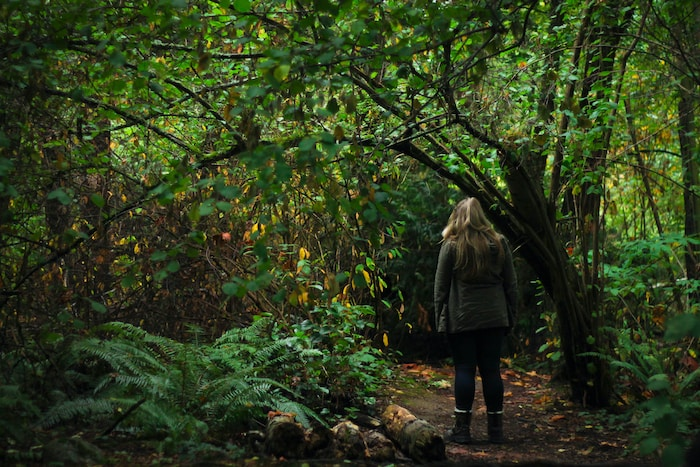

In [7]:
# Load an image from Unsplash.
url = 'https://images.unsplash.com/uploads/14119492946973137ce46/f1f2ebf3?w=700'
image = PIL.Image.open(requests.get(url, stream=True).raw)
print(image)
image

In [8]:
def display_rgb(rgb: np.ndarray) -> go.Figure:
  rgb = np.moveaxis(rgb, 0, -1)  # Channel to end.
  return px.imshow((rgb - rgb.min()) / (rgb.max() - rgb.min()))

In [38]:
hf_preprocessed = hf_processor.image_processor.preprocess(image)["pixel_values"][0]
print(hf_preprocessed.shape)  # Channel, Rows, Cols
fig = display_rgb(hf_preprocessed)
fig.update_layout(title="HuggingFace Preprocessed")


(3, 336, 336)


In [37]:
clip_preprocessed = clip_preprocess(image)
print(clip_preprocessed.shape)
fig = display_rgb(clip_preprocessed.numpy())
fig.update_layout(title="CLIP Preprocessed")

torch.Size([3, 336, 336])


In [24]:
# Highlights areas where the preprocessed pixels are different.
fig = display_rgb(clip_preprocessed.numpy() - hf_preprocessed)
fig.update_layout(title="Differnce: CLIP - HuggingFace")

In [39]:
# Another way to see the difference.
fig = display_rgb(np.abs(clip_preprocessed.numpy() - hf_preprocessed))
fig.update_layout(title="Abs Differnce: CLIP - HuggingFace")

In [30]:
with torch.no_grad():
  hf_embed = hf_model.get_image_features(torch.Tensor(hf_preprocessed).unsqueeze(0)).numpy()[0,:]
  clip_embed = clip_model.encode_image(clip_preprocessed.unsqueeze(0)).numpy()[0,:]
  hf_embed_clip_preprocess = clip_model.encode_image(torch.Tensor(hf_preprocessed).unsqueeze(0)).numpy()[0,:]

In [43]:
fig = px.scatter(x=hf_embed, y=clip_embed)
fig.update_traces(marker_size=2, marker_opacity=0.5)
fig.update_layout(
    title="Different preprocessing yields slight differences in embedding",
    xaxis_title="HF Embed Component",
    yaxis_title="CLIP Embed Component")

In [42]:
fig = px.scatter(x=hf_embed, y=hf_embed_clip_preprocess)
fig.update_traces(marker_size=2, marker_opacity=0.5)
fig.update_layout(
    title="But with the same preprocessing, the models behave identically",
    xaxis_title="HF Embed Component",
    yaxis_title="HF Embed w/ CLIP preprocess")